# XGBoost

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from matplotlib import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
%matplotlib inline

## Loading the data

In [2]:
train = pd.read_csv('clean_train.csv')
test = pd.read_csv('clean_test.csv')

In [3]:
train_X = train.values[:, 1:]
train_y = train.values[:, 0]
test_X = test.values[:, 1:]
test_ID = test.values[:, 0]

### A function to test any model

In [4]:
def test_model(model, train_X = train_X, train_y = train_y, cv_folds=5, early_stopping_rounds=50):
    
    # Using cross validation to figure out the number of trees/number of boosting rounds
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    # perform cross validation for the given parameters on this model and return the error
    cvresult = xgb.cv(xgb_param, xgtrain, nfold=cv_folds, metrics='auc',
                      num_boost_round=model.get_params()['n_estimators'],  # no of rounds same as no of trees
                      early_stopping_rounds=early_stopping_rounds)
                    # CV error needs to decrease at least once in these many rounds.

    # cvresult will return a pandas DataFrame containing the mean error (AUC here) for each iteration until 
    # the metric is increasing. Therefore, we know that after those iterations, the AUC doesn not increase, 
    # therefore we will set the n_estimators to be the number of rows in this data frame
    model.set_params(n_estimators=cvresult.shape[0]) # sets the n_estimators parameter as justified above
    
    # Fit the algorithm on the data
    model.fit(train_X, train_y, eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = model.predict(train_X)
    dtrain_predprob = model.predict_proba(train_X)[:,1]
    
    # Cross validated AUC Score
    scores = cross_val_score(model, train_X, train_y, cv = cv_folds, scoring = 'roc_auc')
        
    # Print model report:
    print ("\nModel Report")
    print ("Optimal number of boosting iterations/number of trees =", cvresult.shape[0])
    print ("Cross validated AUC Score (Train) : %.4g" % scores.mean())
    print ("Accuracy (Train) : %.4g" % metrics.accuracy_score(train_y, dtrain_predictions))
    # print ("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, dtrain_predprob))
                    
    # plotting feature imporatance scores
    rcParams['figure.figsize'] = 6, 3 # increasing figure size to make the plot readable
    xgb.plot_importance(model)

### A function to generate submission file

In [5]:
def generate_submission_file(model, model_name):
    pred_y = model.predict(test_X)
    submission_model = pd.DataFrame({'PassengerId' : test_ID, 'Survived' : pred_y})
    submission_model = submission_model.astype(np.int32)
    submission_model.to_csv('submission_' + model_name + '.csv', index = False)

### Baseline XGBoost Model

I train the XGBoost model without any parameter tuning to setup a baseline.


Model Report
Optimal number of boosting iterations/number of trees = 28
Cross validated AUC Score (Train) : 0.8665
Accuracy (Train) : 0.8406


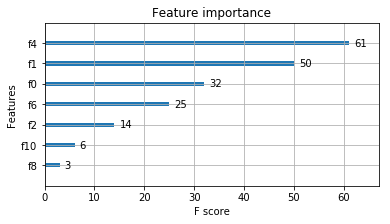

In [6]:
np.random.seed(2017-1-7)
xgb_base = XGBClassifier()
test_model(xgb_base)

#### Generating submission file for base model

In [7]:
generate_submission_file(xgb_base, 'xgb_base')

## Tuning the XGBoost Model

#### Step 1: Fix learning rate and tree-based parameters to for tuning number of estimators/trees


Model Report
Optimal number of boosting iterations/number of trees = 58
Cross validated AUC Score (Train) : 0.8678
Accuracy (Train) : 0.8923


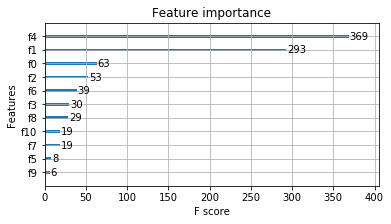

In [8]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)

test_model(xgb1)

We got 58 as the optimal number of trees for 0.1 as the learning rate.

#### Step 2: Tune `max_depth` and `min_child_weight`

In [40]:
param_test1 = {
 'max_depth':range(1,20,2), # since this data set is small, we can afford to check each value from 1 to 20
 'min_child_weight':range(1,20,2) # but these intervals should be less finer for large data sets
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=58, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4, scale_pos_weight=1, seed=27),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch1.fit(train_X, train_y)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 13, 'min_child_weight': 1}, 0.87490549755255631)

The AUC increased from last time. Now, because we iterated in steps of 2 in the grids, we must check for optimal values in 12, 13, and 14. We do this as follows:

In [41]:
param_test2 = {
 'max_depth':[12, 13, 14],
 'min_child_weight':[0, 1, 2]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=58, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4, scale_pos_weight=1, seed=27),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch2.fit(train_X, train_y)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 13, 'min_child_weight': 1}, 0.87490549755255631)

Therefore, we confirm that 13 and 1 are indeed the optimal values for `max_depth` and `min_child_weight`. The cross validate AUC is 0.8749. Let's tune the other parameters.

#### Step 3: Tune gamma

In [22]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=58, max_depth=13,
                                                  min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, 
                                                  scale_pos_weight=1, seed=27), 
                        param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch3.fit(train_X, train_y)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.6}, 0.87495645530939647)

Slight increase in AUC. Let't try to fine tune gamma around the 0.6.

In [26]:
param_test4 = {
 'gamma':[i/100.0 for i in range(51,70)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=58, max_depth=13,
                                                  min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, 
                                                  scale_pos_weight=1, seed=27), 
                        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch4.fit(train_X, train_y)
gsearch4.best_params_, gsearch4.best_score_

({'gamma': 0.55}, 0.87522018504371446)

There is much bigger increase in AUC after fine_tuning gamma. 

Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.


Model Report
Optimal number of boosting iterations/number of trees = 25
Cross validated AUC Score (Train) : 0.8762
Accuracy (Train) : 0.9035


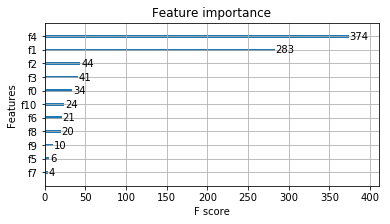

In [27]:
xgb2 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=13,
    min_child_weight=1,
    gamma=0.55,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

test_model(xgb2)

The number of trees have decreased to 25 now.

#### Step 4: Tune subsample and colsample_bytree

In [28]:
param_test5 = {
 'subsample':[i/10.0 for i in range(1,10)],
 'colsample_bytree':[i/10.0 for i in range(1,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=25, max_depth=13,
                                                  min_child_weight=1, gamma=0.55, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch5.fit(train_X, train_y)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.7}, 0.87942200718671304)

Again, fine tuning around the optimal values is a good idea.

In [29]:
param_test6 = {
 'subsample':[i/100.0 for i in range(41, 60)],
 'colsample_bytree':[i/100.0 for i in range(61,80)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=25, max_depth=13,
                                                  min_child_weight=1, gamma=0.55, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch6.fit(train_X, train_y)
gsearch6.best_params_, gsearch6.best_score_

({'colsample_bytree': 0.61, 'subsample': 0.59}, 0.87982389723566201)

Fine tuning results in further increase in the AUC.

#### Step 5: Tuning Regularization Parameters

Regularization might decrease the AUC score but it also prevents overfitting and reduces variance. Therefore, a good idea will be to submit two solutions, one with regularizationm and one without to see which one performs better.

In [31]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=25, max_depth=13,
                                                  min_child_weight=1, gamma=0.55, subsample=0.59, 
                                                  colsample_bytree=0.61, objective= 'binary:logistic', 
                                                  nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch7.fit(train_X, train_y)
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 0.01}, 0.87997362985598282)

Here we find that regularization infact results in an increase in AUC. Fine tuning around the optimal value.

In [33]:
param_test8 = {
 'reg_alpha':[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=25, max_depth=13,
                                                  min_child_weight=1, gamma=0.55, subsample=0.59, 
                                                  colsample_bytree=0.61, objective= 'binary:logistic', 
                                                  nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch8.fit(train_X, train_y)
gsearch8.best_params_, gsearch8.best_score_

({'reg_alpha': 0.006}, 0.88035865659395063)

#### Looking at the impact of all the regularized parameters


Model Report
Optimal number of boosting iterations/number of trees = 100
Cross validated AUC Score (Train) : 0.874
Accuracy (Train) : 0.9125


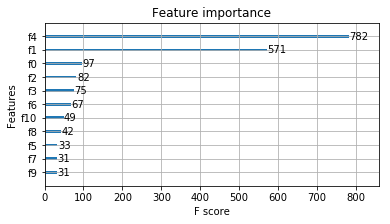

In [34]:
xgb3 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=13,
    min_child_weight=1,
    gamma=0.55,
    subsample=0.59,
    colsample_bytree=0.61,
    reg_alpha=0.006,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1, 
    seed=27)

test_model(xgb3)

#### Step 6: Reducing Learning Rate

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.


Model Report
Optimal number of boosting iterations/number of trees = 63
Cross validated AUC Score (Train) : 0.8757
Accuracy (Train) : 0.8878


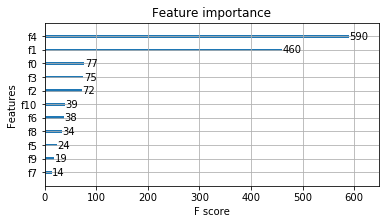

In [36]:
xgb4 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=5000,
    max_depth=13,
    min_child_weight=1,
    gamma=0.55,
    subsample=0.59,
    colsample_bytree=0.61,
    reg_alpha=0.006,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

test_model(xgb4)

In [38]:
param_test9 = {
 'learning_rate':[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05],
    'n_estimators':[100, 500, 1000, 2000, 5000]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=25, max_depth=13,
                                                  min_child_weight=1, gamma=0.55, subsample=0.59, 
                                                  colsample_bytree=0.61, objective= 'binary:logistic', 
                                                  nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=10)

gsearch9.fit(train_X, train_y)
gsearch9.best_params_, gsearch8.best_score_

({'learning_rate': 0.003, 'n_estimators': 1000}, 0.87846724952607291)

## Final Prediction and submission

In [39]:
generate_submission_file(gsearch8, 'xgb_fine_tuned')